In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import shap

In [2]:
DATA_DIR = '../Plant_leave_diseases_dataset_without_augmentation'
MODEL_SAVE_PATH = 'models/plant_disease_model_resnet50.h5'
CLASS_NAMES_PATH = 'class_names.py'
IMAGE_SAVE_DIR = "images/"
os.makedirs(IMAGE_SAVE_DIR, exist_ok=True)
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 25918 images belonging to 26 classes.
Found 6470 images belonging to 26 classes.


In [6]:
def build_model(num_classes):
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model, resnet_base = build_model(train_generator.num_classes)


In [7]:
# ================================
# 2. SAUVEGARDE DES NOMS DE CLASSES
# ================================
index_to_class = {v: k for k, v in train_generator.class_indices.items()}
class_names = [index_to_class[i] for i in range(len(index_to_class))]

with open(CLASS_NAMES_PATH, 'w') as f:
    f.write(f"class_names = {class_names}\n")


In [8]:
# ================================
# 3. CONSTRUCTION DU MODÈLE RESNET50
# ================================
def build_model(num_classes):
    base_model = ResNet50(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Geler le backbone pour l'entraînement initial

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name='disease_classifier_resnet50')
    return model, base_model

model, resnet_base = build_model(train_generator.num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "disease_classifier_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,118,938 (92.01 MB)

 Trainable params: 531,226 (2.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# ================================
# 4. CALLBACKS
# ================================
callbacks = [
    EarlyStopping(patience=8, monitor='val_accuracy', restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

In [10]:
# ================================
# 5. ENTRAÎNEMENT INITIAL
# ================================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.7667 - loss: 0.8400   
Epoch 1: val_accuracy improved from None to 0.96615, saving model to models/plant_disease_model_resnet50.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 782s 957ms/step - accuracy: 0.8716 - loss: 0.4362 - val_accuracy: 0.9662 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9411 - loss: 0.1763  
Epoch 2: val_accuracy improved from 0.96615 to 0.97604, saving model to models/plant_disease_model_resnet50.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 729s 900ms/step - accuracy: 0.9451 - loss: 0.1650 - val_accuracy: 0.9760 - val_loss: 0.0770 - learning_rate: 0.0010
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9515 - loss: 0.1409  
Epoch 3: val_accuracy improved from 0.97604 to 0.97774, saving model to models/plant_disease_model_resnet50.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 737s 910ms/step - accuracy: 0.9537 - loss: 0.1352 - val_accuracy: 0.9777 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9565 - loss: 0.1249   
Epoch 4: val_accuracy improved from 0.97774 to 0.97929, saving model to models/plant_disease_model_resnet50.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 748s 923ms/step - accuracy: 0.9587 - loss: 0.1228 - val_accuracy: 0.9793 - val_loss: 0.0624 - learning_rate: 0.0010
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.9634 - loss: 0.1098  
Epoch 5: val_accuracy did not improve from 0.97929
810/810 ━━━━━━━━━━━━━━━━━━━━ 740s 914ms/step - accuracy: 0.9637 - loss: 0.1081 - val_accuracy: 0.9723 - val_loss: 0.0823 - learning_rate: 0.0010
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.9620 - loss: 0.1135   
Epoch 6: val_accuracy improved from 0.97929 to 0.98532, saving model to models/plant_disease_model_resnet50.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 882s 1s/step - accuracy: 0.9618 - loss: 0.1119 - val_accuracy: 0.9853 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9650 - loss: 0.1002  
Epoch 7: val_accuracy did not improve from 0.98532
810/810 ━━━━━━━━━━━━━━━━━━━━ 743s 917ms/step - accuracy: 0.9645 - loss: 0.1016 - val_accuracy: 0.9794 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9677 - loss: 0.0964  
Epoch 8: val_accuracy did not improve from 0.98532
810/810 ━━━━━━━━━━━━━━━━━━━━ 738s 911ms/step - accuracy: 0.9697 - loss: 0.0925 - val_accuracy: 0.9844 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 9/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.9674 - loss: 0.1017  
Epoch 9: val_accuracy did not improve from 0.98532
810/810 ━━━━━━━━━━━━━━━━━━━━ 739s 912ms/step - accuracy: 0.9680 - loss: 0.0986 - val_accuracy: 0.9847 - val_loss: 0.0500 - learning_rate: 0.0010


In [11]:
model.save("models/plant_disease_model_resnet50.keras")

In [12]:
import pickle
with open("models/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

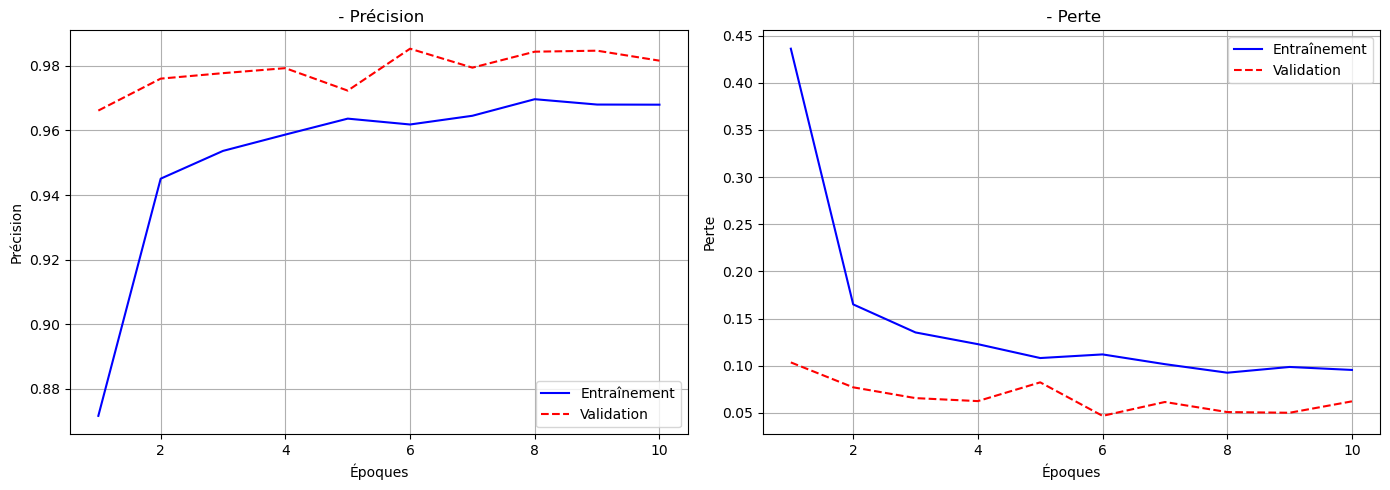

In [15]:
# ================================
# 6. AFFICHAGE DES COURBES D'APPRENTISSAGE
# ================================

title_prefix=""
filename_prefix="curve2"
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
    
plt.figure(figsize=(14, 5))
    
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Entraînement')
plt.plot(epochs, val_acc, 'r--', label='Validation')
plt.title(f'{title_prefix} - Précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)
    
# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Entraînement')
plt.plot(epochs, val_loss, 'r--', label='Validation')
plt.title(f'{title_prefix} - Perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)
    
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_SAVE_DIR, f"{filename_prefix}.png"))
plt.show()



203/203 ━━━━━━━━━━━━━━━━━━━━ 131s 637ms/step


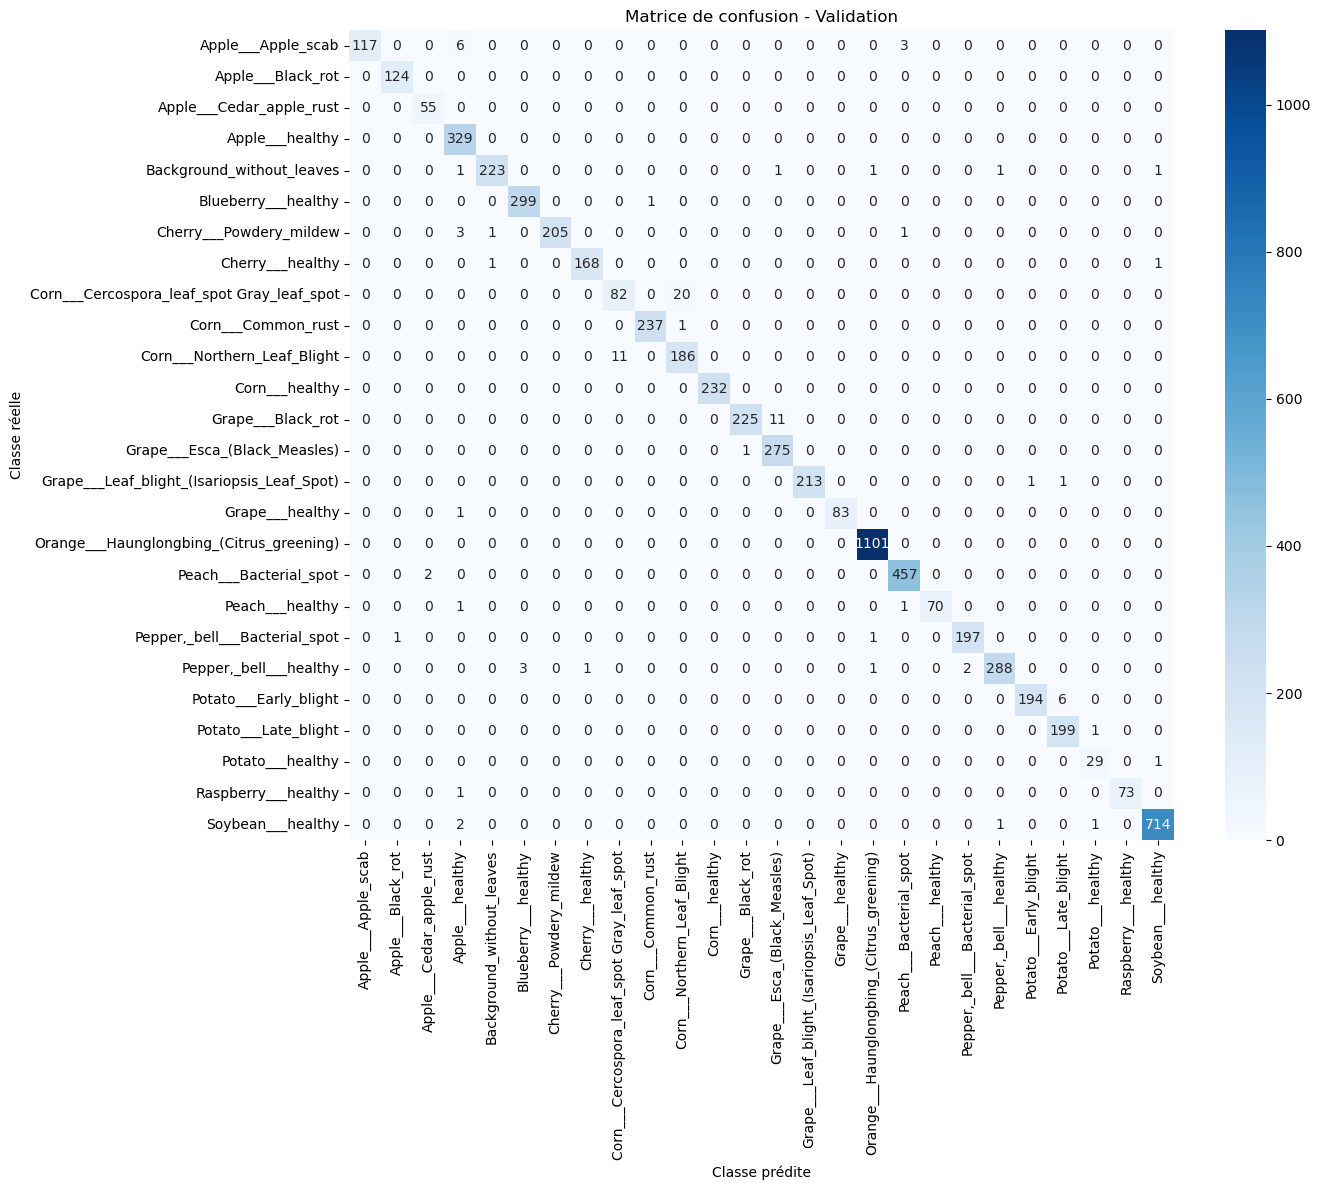

In [14]:
# ================================
# 7. MATRICE DE CONFUSION
# ================================
val_generator.reset()
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion - Validation')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_SAVE_DIR, "confusion_matrix.png"))
plt.show()


In [17]:
# ================================
# 8. RAPPORT DE CLASSIFICATION
# ================================
report = classification_report(y_true, y_pred, target_names=class_names)
print("=== Rapport de classification ===\n")
print(report)


=== Rapport de classification ===

                                            precision    recall  f1-score   support

                        Apple___Apple_scab       1.00      0.93      0.96       126
                         Apple___Black_rot       0.99      1.00      1.00       124
                  Apple___Cedar_apple_rust       0.96      1.00      0.98        55
                           Apple___healthy       0.96      1.00      0.98       329
                 Background_without_leaves       0.99      0.98      0.98       228
                       Blueberry___healthy       0.99      1.00      0.99       300
                   Cherry___Powdery_mildew       1.00      0.98      0.99       210
                          Cherry___healthy       0.99      0.99      0.99       170
Corn___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.80      0.84       102
                        Corn___Common_rust       1.00      1.00      1.00       238
               Corn___Northern_Leaf_Blig

In [31]:
model.save(MODEL_SAVE_PATH)

C:\Users\hassa\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_354
Received: inputs=['Tensor(shape=(5, 224, 224, 3))']
  warnings.warn(msg)
C:\Users\hassa\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_354
Received: inputs=['Tensor(shape=(10, 224, 224, 3))']
  warnings.warn(msg)


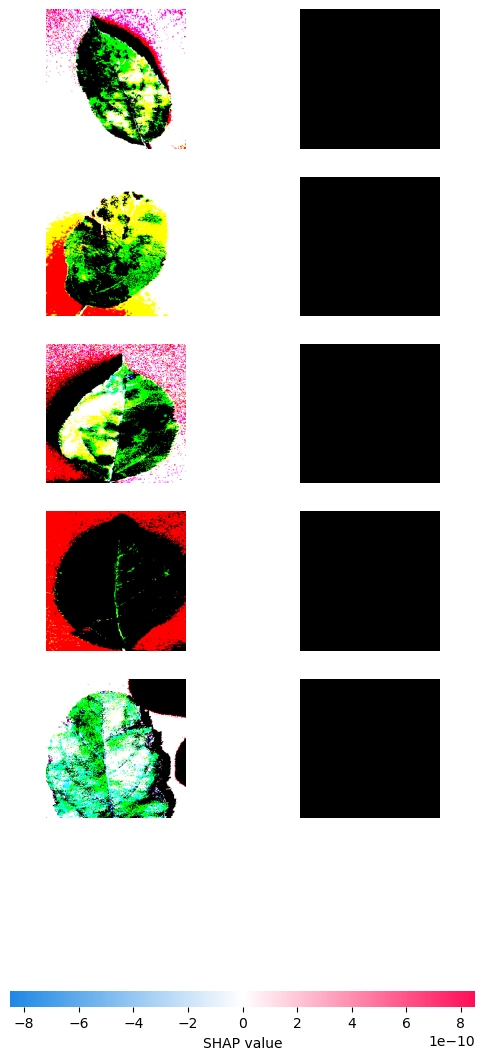

In [24]:
import shap
#expliquer la contribution de chaque pixel (ou feature) aux prédictions de ton modèle.
# Prendre un petit batch d'images et labels
X_sample, y_sample = next(val_generator)
X_sample = X_sample[:5]  # petit batch pour mémoire

explainer = shap.DeepExplainer(model, X_sample)
shap_values = explainer.shap_values(X_sample)

# Affichage pour la première image
shap.image_plot(shap_values, X_sample)


In [14]:
model = load_model('models\plant_disease_model_resnet50.keras')

C:\Users\hassa\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


C:\Users\hassa\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_2
Received: inputs=['Tensor(shape=(5, 224, 224, 3))']
  warnings.warn(msg)
C:\Users\hassa\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_2
Received: inputs=['Tensor(shape=(10, 224, 224, 3))']
  warnings.warn(msg)


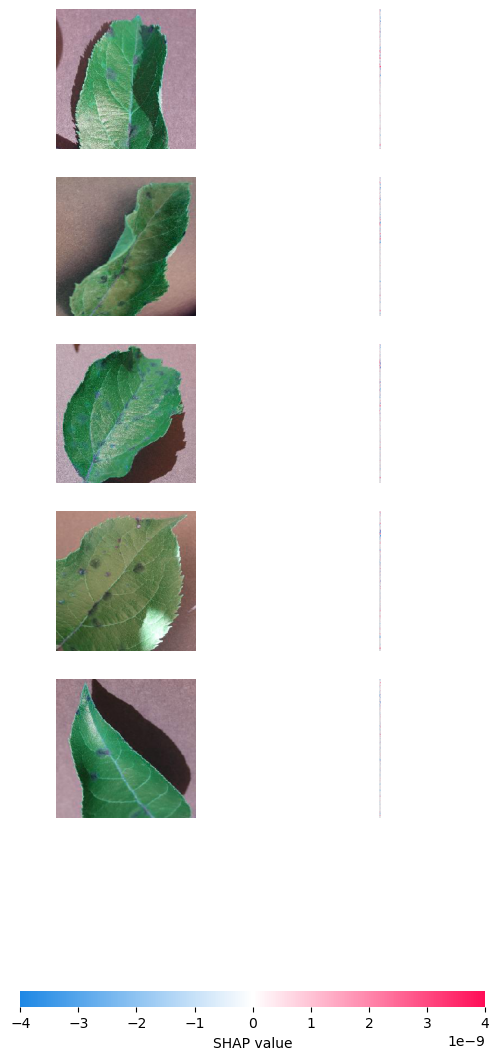

In [17]:
X_sample, y_sample = next(val_generator)
X_batch = X_sample[:5]   # petit batch pour mémoire

# Prédictions
y_pred = np.argmax(model.predict(X_batch), axis=1)
explainer = shap.DeepExplainer(model, X_batch)
shap_values = explainer.shap_values(X_batch)

# shap_values est une liste avec une matrice par classe
# On récupère pour chaque image la classe prédite
shap_vals_for_pred_class = np.array([
    shap_values[class_idx][i] for i, class_idx in enumerate(y_pred)
])

# Rescaler les images pour affichage matplotlib
X_display = X_batch.copy()
# Inverse preprocessing ResNet50
X_display += np.array([103.939, 116.779, 123.68])
X_display = np.clip(X_display, 0, 255).astype(np.uint8)

# Affichage SHAP
shap.image_plot([shap_vals_for_pred_class], X_display)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

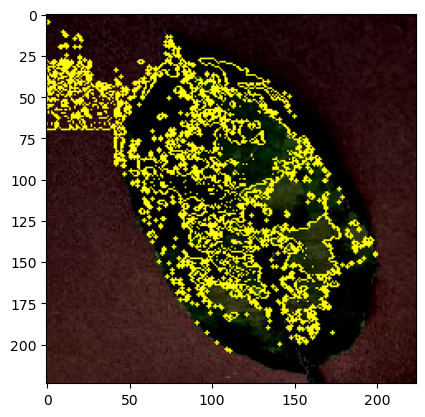

In [25]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    X_sample[0],                # une image
    model.predict,              # fonction de prédiction
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Affichage de la zone importante
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.show()
